In [266]:
!pip install missingno

In [267]:
!pip install tensorflow

In [268]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns",None)
import warnings
warnings.filterwarnings("ignore")

In [317]:
from datetime import date
from lightgbm import LGBMClassifier
from keras.models import Sequential
from keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.model_selection import cross_val_score

In [270]:
data = pd.read_csv("diabetes.csv")

In [271]:
df = data.copy()

In [272]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [273]:
def check_df(dataframe, satir_sayisi):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(satir_sayisi))
    print("##################### Tail #####################")
    print(dataframe.tail(satir_sayisi))
    print("##################### NA #####################")
    print(dataframe.isnull().sum().sort_values(ascending=False))
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [274]:
check_df(df,10)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   
5            5      116             74              0        0  25.6   


In [275]:
df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [276]:
df["Outcome"].value_counts()/len(df)*100

0    65.104167
1    34.895833
Name: Outcome, dtype: float64

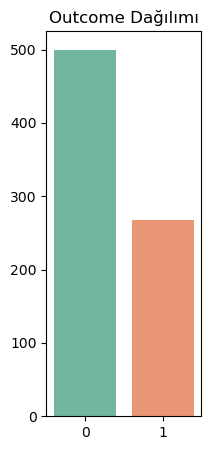

In [277]:
Tani = df.Outcome.value_counts().index
Sayi = df.Outcome.value_counts().values

plt.figure(figsize=(2,5))
sns.set_palette("Set2")
sns.barplot(x=Tani, y=Sayi)
plt.title("Outcome Dağılımı")
plt.xticks(rotation=0)
plt.show()

Correlation of:  Pregnancies


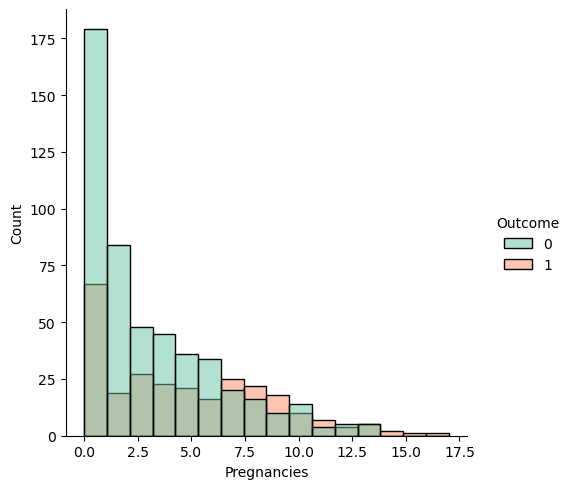

Correlation of:  Glucose


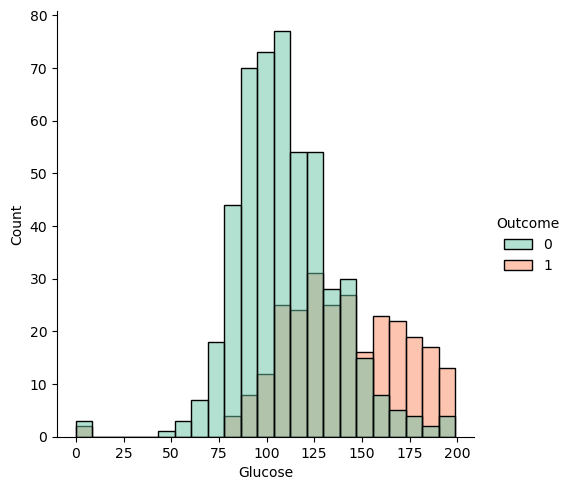

Correlation of:  BloodPressure


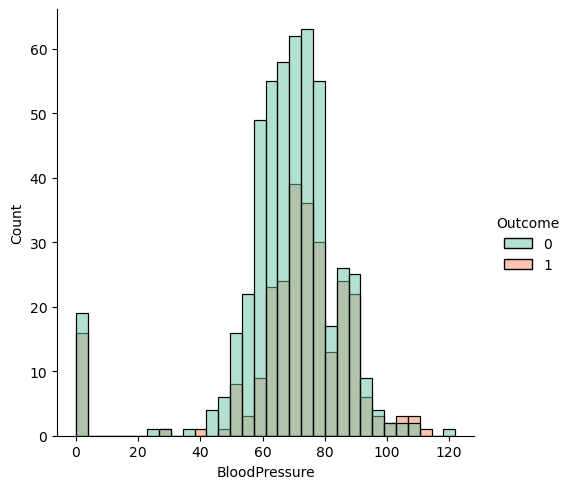

Correlation of:  SkinThickness


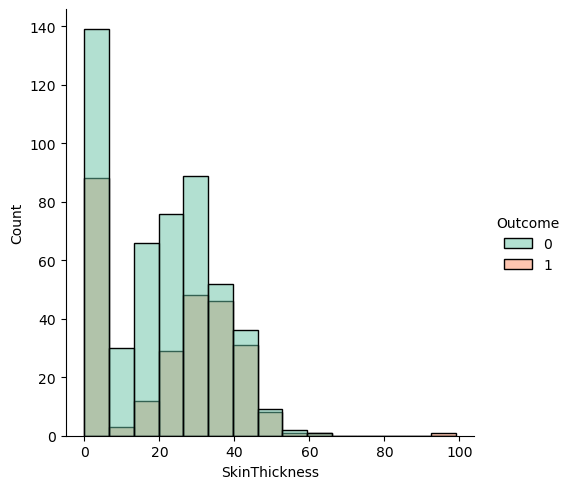

Correlation of:  Insulin


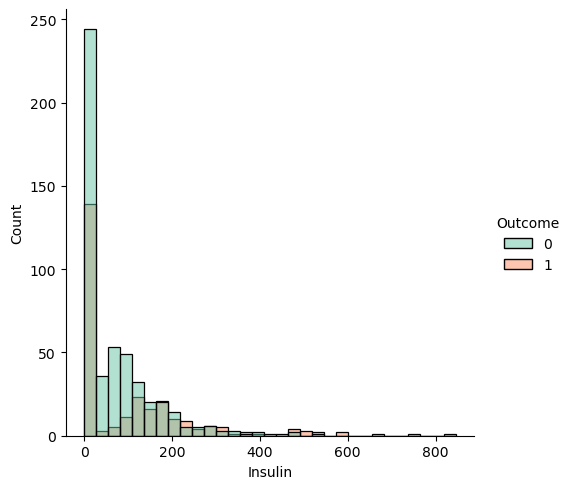

Correlation of:  BMI


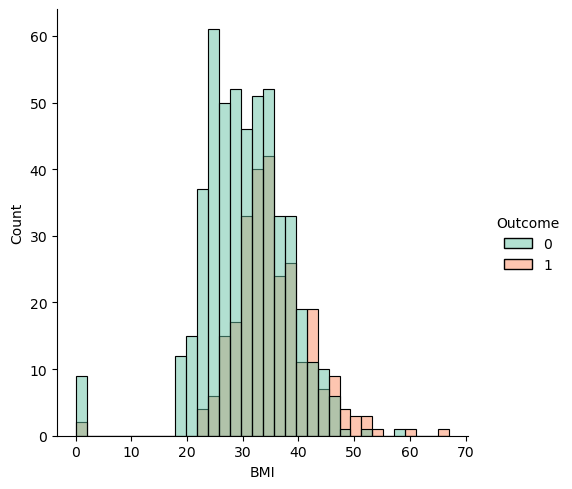

Correlation of:  DiabetesPedigreeFunction


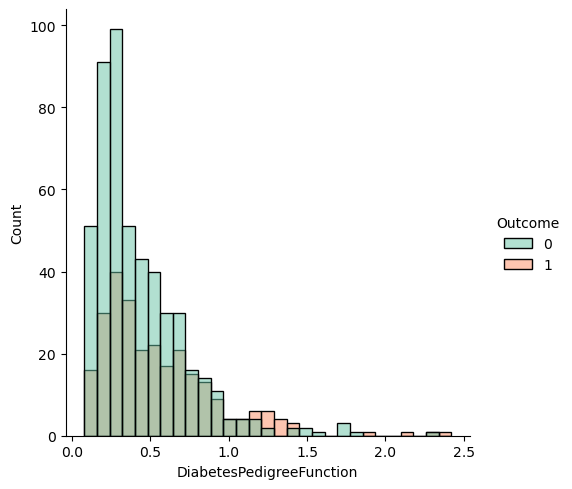

Correlation of:  Age


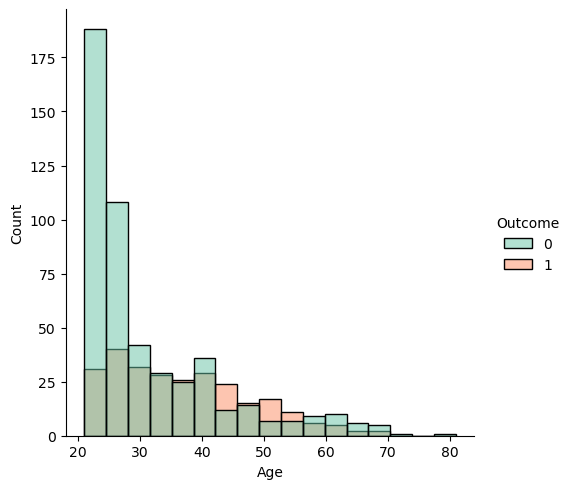

Correlation of:  Outcome


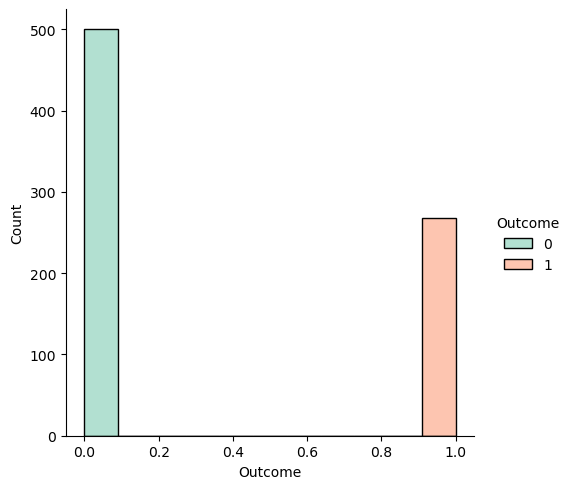

In [278]:
for columns in df.columns:
    print("Correlation of: ", columns)
    sns.displot(df, x=columns , kind='hist' , hue='Outcome', color="#FF8300")
    plt.show()

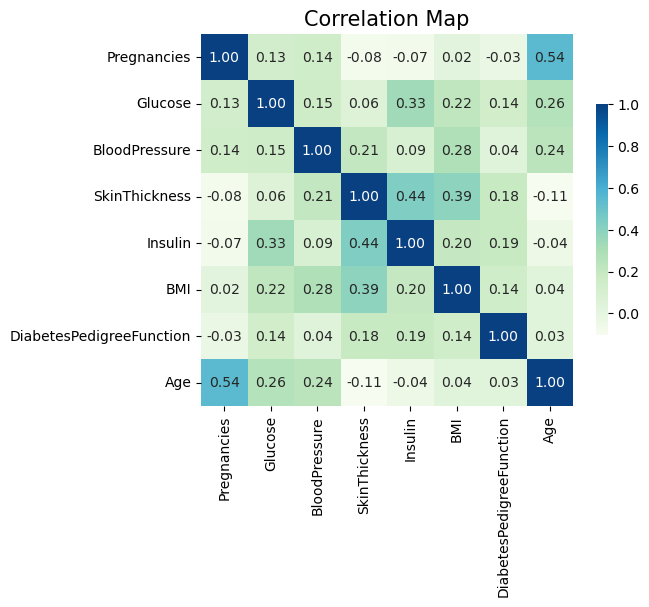

In [279]:
df_corr = df[num_cols].corr()
plt.figure(figsize=(6,6))
ax = sns.heatmap(df_corr,vmax=1,square=True, annot=True,fmt='.2f',cmap='GnBu',cbar_kws={"shrink": .5},robust=True)
plt.title('Correlation Map', fontsize=15)
plt.show()

In [280]:
def grab_col_names (dataframe, categorical = 10, cardinal =20):

    # categoricals
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == 'O']
    #  [col for col in df.columns if str(df[col].dtypes) in ["category","object","bool"]]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtype == 'O' and
                   dataframe[col].nunique() > cardinal]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtype != 'O' and
                   dataframe[col].nunique() < categorical]
    cat_cols += num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # numericals

    num_cols = [col for col in dataframe.columns if dataframe[col].dtype != 'O' and
                col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names (df, categorical = 10, cardinal =20)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [281]:
df.groupby('Pregnancies').agg({'Outcome': ['mean', 'sum']}).reset_index().\
    sort_values(by = ('Outcome','sum'),ascending = False)

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")
    
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: 'mean'}))
    print("----------------------------------------")
for col in num_cols:
    target_summary_with_num(df, 'Outcome', col)

         Pregnancies
Outcome             
0           3.298000
1           4.865672
----------------------------------------
            Glucose
Outcome            
0        109.980000
1        141.257463
----------------------------------------
         BloodPressure
Outcome               
0            68.184000
1            70.824627
----------------------------------------
         SkinThickness
Outcome               
0            19.664000
1            22.164179
----------------------------------------
            Insulin
Outcome            
0         68.792000
1        100.335821
----------------------------------------
               BMI
Outcome           
0        30.304200
1        35.142537
----------------------------------------
         DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500
----------------------------------------
               Age
Outcome           
0        31.190000
1        37.0671

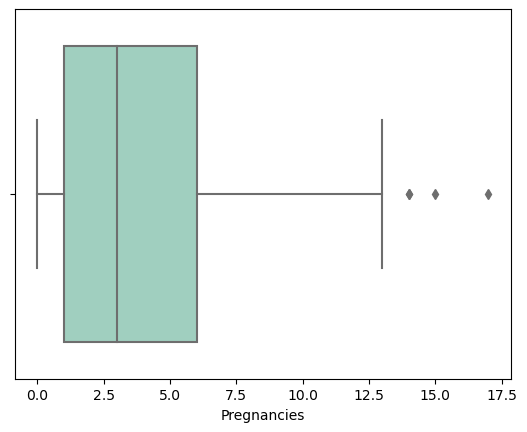

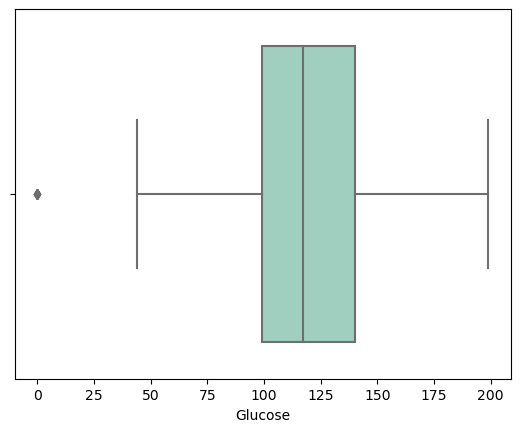

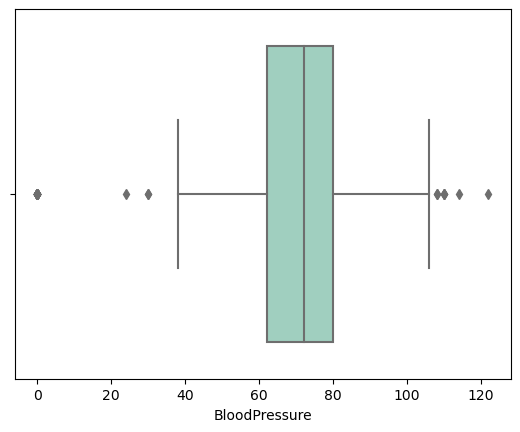

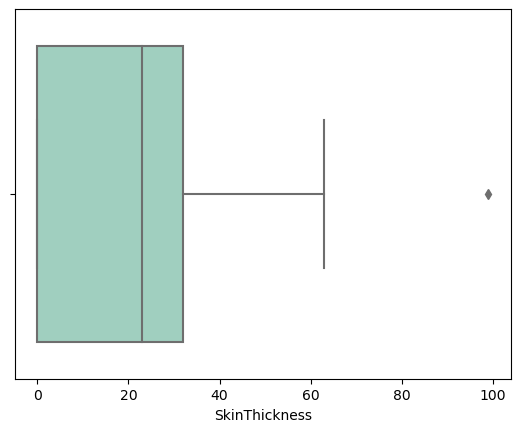

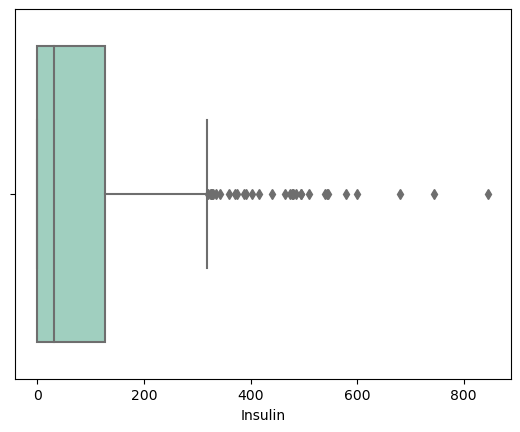

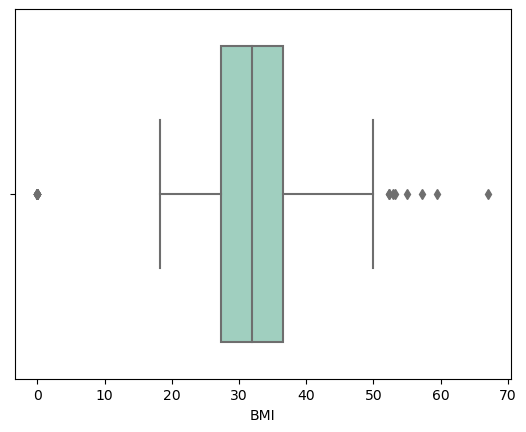

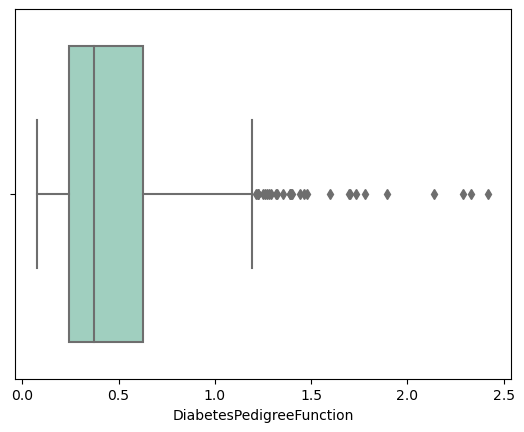

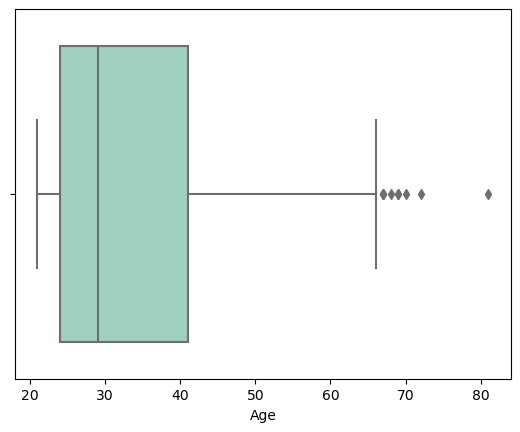

In [282]:
for col in num_cols:
    sns.boxplot(x=df[col], color="#98D7C2")
    plt.show()

In [283]:
def outlier_thresholds(dataframe, col_name, q1=0.10, q3=0.90):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index
    
    
grab_outliers(df, 'Pregnancies', True)
grab_outliers(df, 'Glucose', True)
grab_outliers(df, 'BloodPressure',True)
grab_outliers(df, 'Insulin',True)
grab_outliers(df, 'BMI',True)
grab_outliers(df, 'DiabetesPedigreeFunction',True)
grab_outliers(df, 'Age',True)

Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []
    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
7            10      115              0              0        0  35.3   
15            7      100              0              0        0  30.0   
49            7      105              0              0        0   0.0   
60            2       84              0              0        0   0.0   
78            0      131              0              0        0  43.2   

    DiabetesPedigreeFunction  Age  Outcome  
7                      0.134   29        0  
15                     0.484   32        1  
49                     0.305   24        0  
60                     0.304   21        0  
78                     0.270   26        1  
     Pr

Int64Index([], dtype='int64')

In [284]:
print("Missing Values by Column")
print("-"*30)
print(df.isnull().sum())
print("-"*30)
print("TOTAL MISSING VALUES:",df.isna().sum().sum())

Missing Values by Column
------------------------------
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
------------------------------
TOTAL MISSING VALUES: 0


In [285]:
df['BMI'].replace(0, np.nan , inplace = True)
df['BloodPressure'].replace(0, np.nan , inplace = True)
df['Insulin'].replace(0, np.nan , inplace = True)
df['Glucose'].replace(0, np.nan , inplace = True)
df['SkinThickness'].replace(0, np.nan , inplace = True)

df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [286]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
5,5,116.0,74.0,NaN,NaN,25.6,0.201,30,0
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
7,10,115.0,NaN,NaN,NaN,35.3,0.134,29,0
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
9,8,125.0,96.0,NaN,NaN,NaN,0.232,54,1


In [287]:
df["Glucose"].fillna(df["Glucose"].median(), inplace=True)

In [288]:
df["BloodPressure"].fillna(df["BloodPressure"].median(), inplace=True)

In [289]:
df["SkinThickness"].fillna(df["SkinThickness"].median(), inplace=True)

In [290]:
df["Insulin"].fillna(df["Insulin"].median(), inplace=True)

In [291]:
df["BMI"].fillna(df["BMI"].median(), inplace=True)

In [292]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
5,5,116.0,74.0,29.0,125.0,25.6,0.201,30,0
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
7,10,115.0,72.0,29.0,125.0,35.3,0.134,29,0
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
9,8,125.0,96.0,29.0,125.0,32.3,0.232,54,1


In [293]:
df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [294]:
df["Pregnancies"].value_counts()

1     135
0     111
2     103
3      75
4      68
5      57
6      50
7      45
8      38
9      28
10     24
11     11
13     10
12      9
14      2
15      1
17      1
Name: Pregnancies, dtype: int64

In [295]:
df.loc[(df["Pregnancies"]==0),"New_Pegnancies"] = "Never"
df.loc[(df["Pregnancies"]==1),"New_Pegnancies"] = "Once"
df.loc[(df["Pregnancies"]>=2),"New_Pegnancies"] = "Many Times"

In [296]:
df['New_Glucose'] = pd.cut(x = df['Glucose'], bins = [-1,80,140,160,200],
                               labels = ['Hypoglycemia','Normal', 'Prediabetes', 'Diabetic_Glucose'])

In [297]:
df['New_Age'] = pd.cut( x = df['Age'], bins = [0,18,44,64,100],
                               labels = ['Child','Adults', 'MiddleAged','Old'])

In [298]:
df['New_Blood_Pressure'] = pd.cut(x = df['BloodPressure'], bins = [0,80,89,120,300],
                               labels = ['Normal', 'High_Blood_Pressure' , 'Hypertension', 'Hypertension_Crisis'])

In [299]:
df['New_Insulin'] = pd.cut(x= df['Insulin'], bins = [0, 120, 1000], labels = ['Normal','Abnormal'])

In [300]:
df['New_BMI'] = pd.cut(x = df['BMI'], bins = [0,18,25,29,68], labels = ['Underweight', 'Normal', 'Overweight', 'Obesity'])

In [301]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,New_Pegnancies,New_Glucose,New_Age,New_Blood_Pressure,New_Insulin,New_BMI
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1,Many Times,Prediabetes,MiddleAged,Normal,Abnormal,Obesity
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0,Once,Normal,Adults,Normal,Abnormal,Overweight
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1,Many Times,Diabetic_Glucose,Adults,Normal,Abnormal,Normal
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Once,Normal,Adults,Normal,Normal,Overweight
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Never,Normal,Adults,Normal,Abnormal,Obesity
5,5,116.0,74.0,29.0,125.0,25.6,0.201,30,0,Many Times,Normal,Adults,Normal,Abnormal,Overweight
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1,Many Times,Hypoglycemia,Adults,Normal,Normal,Obesity
7,10,115.0,72.0,29.0,125.0,35.3,0.134,29,0,Many Times,Normal,Adults,Normal,Abnormal,Obesity
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1,Many Times,Diabetic_Glucose,MiddleAged,Normal,Abnormal,Obesity
9,8,125.0,96.0,29.0,125.0,32.3,0.232,54,1,Many Times,Normal,MiddleAged,Hypertension,Abnormal,Obesity


In [305]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)


def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

for col in binary_cols:
    df = label_encoder(df, col)

Observations: 768
Variables: 15
cat_cols: 7
num_cols: 8
cat_but_car: 0
num_but_cat: 6


In [306]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Outcome"]]
cat_cols

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,New_Pegnancies_Never,New_Pegnancies_Once,New_Glucose_Normal,New_Glucose_Prediabetes,New_Glucose_Diabetic_Glucose,New_Age_Adults,New_Age_MiddleAged,New_Age_Old,New_Blood_Pressure_High_Blood_Pressure,New_Blood_Pressure_Hypertension,New_Blood_Pressure_Hypertension_Crisis,New_Insulin_Abnormal,New_BMI_Normal,New_BMI_Overweight,New_BMI_Obesity
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1


In [309]:
scaler = MinMaxScaler()
model=scaler.fit(df)
scaled=model.transform(df)
df_scaled = pd.DataFrame(scaled, index=df.index, columns=df.columns)
df_scaled= df
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,New_Pegnancies_Never,New_Pegnancies_Once,New_Glucose_Normal,New_Glucose_Prediabetes,New_Glucose_Diabetic_Glucose,New_Age_Adults,New_Age_MiddleAged,New_Age_Old,New_Blood_Pressure_High_Blood_Pressure,New_Blood_Pressure_Hypertension,New_Blood_Pressure_Hypertension_Crisis,New_Insulin_Abnormal,New_BMI_Normal,New_BMI_Overweight,New_BMI_Obesity
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1


In [329]:
x = df.drop(['Outcome'],axis=1)
y = df['Outcome']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=1)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 23), (154, 23), (614,), (154,))

In [330]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train,y_train)
prediction = knn.predict(x_test)
print("K=3 için Test verilerimizin doğrulama testi sonucu ", knn.score(x_test, y_test))


K=3 için Test verilerimizin doğrulama testi sonucu  0.7402597402597403


In [331]:
sayac = 1
for k in range(1,11):
    knn_yeni = KNeighborsClassifier(n_neighbors = k)
    knn_yeni.fit(x_train,y_train)
    print(sayac, "  ", "Doğruluk oranı: %", knn_yeni.score(x_test,y_test)*100)
    sayac += 1

1    Doğruluk oranı: % 68.83116883116884
2    Doğruluk oranı: % 73.37662337662337
3    Doğruluk oranı: % 74.02597402597402
4    Doğruluk oranı: % 75.97402597402598
5    Doğruluk oranı: % 74.02597402597402
6    Doğruluk oranı: % 78.57142857142857
7    Doğruluk oranı: % 75.97402597402598
8    Doğruluk oranı: % 77.27272727272727
9    Doğruluk oranı: % 77.92207792207793
10    Doğruluk oranı: % 76.62337662337663


In [332]:
def knn_model(x,y):
    x_train,x_test, y_train, y_test=train_test_split(x,y, test_size=0.2,random_state=1)
    knn_model=KNeighborsClassifier().fit(x_train,y_train)
    y_pred=knn_model.predict(x_test)
    print('Test Confusion Matrix:\n', confusion_matrix(y_test,y_pred))
    print("Accuracy Score  : ", accuracy_score(y_test,y_pred))
    print("Cross Val Score  : ",cross_val_score(knn_model,x_test,y_test,cv=10).mean())
    print("Classification Report:\n",classification_report(y_test,y_pred))

In [328]:
knn_model(x,y)

Test Confusion Matrix:
 [[70 29]
 [21 34]]
Accuracy Score  :  0.6753246753246753
Cross Val Score  :  0.7279166666666665
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.71      0.74        99
           1       0.54      0.62      0.58        55

    accuracy                           0.68       154
   macro avg       0.65      0.66      0.66       154
weighted avg       0.69      0.68      0.68       154

